In [2]:
#Data handling
import h5py

import logging
#Mathematical libraries
import numpy as np

import pandas as pd

%matplotlib inline

import bottleneck

import matplotlib.pyplot as plt

In [3]:
df_go_id_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_mapping_v2.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
df_go_id_enseml.dropna(subset=['Gene stable ID'])
mydict_EID_UID = dict(zip(df_go_id_enseml['Gene stable ID'], df_go_id_enseml['Transcript stable ID']))

In [4]:
df_ncbi_gene_type_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_NCBI_gene_type.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
mydict_EID_NID = dict(zip(df_ncbi_gene_type_enseml['Gene stable ID'], df_ncbi_gene_type_enseml['NCBI gene (formerly Entrezgene) ID']))
mydict_EID_genetype = dict(zip(df_ncbi_gene_type_enseml['Gene stable ID'], df_ncbi_gene_type_enseml['Gene type']))

In [265]:
df_ncbi_gene_type_enseml'/data/lohia/gene_distance_expresseion/mart_export_ensg_uni_genetype.txt'

Gene stable ID Transcript stable ID             Gene type  \
0       ENSG00000210049      ENST00000387314               Mt_tRNA   
1       ENSG00000211459      ENST00000389680               Mt_rRNA   
2       ENSG00000210077      ENST00000387342               Mt_tRNA   
3       ENSG00000210082      ENST00000387347               Mt_rRNA   
4       ENSG00000209082      ENST00000386347               Mt_tRNA   
...                 ...                  ...                   ...   
254182  ENSG00000285363      ENST00000642800  processed_pseudogene   
254183  ENSG00000285114      ENST00000645112        protein_coding   
254184  ENSG00000285114      ENST00000642712        protein_coding   
254185  ENSG00000285114      ENST00000646090        protein_coding   
254186  ENSG00000285114      ENST00000643960        protein_coding   

        NCBI gene (formerly Entrezgene) ID  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
...                                    ...  
254182                                 NaN  
254183                             56169.0  
254184                             56169.0  
254185                             56169.0  
254186                             56169.0  

[254187 rows x 4 columns]

In [5]:
from scipy.sparse import coo_matrix
#df_go_id_enseml = pd.read_csv('/data/johlee/geneIDConversions/9606_gene_info.tab', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
#df_go_id_enseml.dropna(subset=['EnsemblID'])
#mydict_EID_UID = dict(zip(df_go_id_enseml.EnsemblID, df_go_id_enseml.UniProtID))
def parse_go_hd5(filename, mydict_EID_UID=mydict_EID_UID):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        for x in columns:
            try:
                v = mydict_EID_UID[x]
                col_uid.append(x)
            except KeyError:
                print (x)
                col_uid.append('del')
        #col_uid = [mydict_EID_UID[x] for x in columns]
        logging.debug("making dataframe...")

        print (coo.toarray().shape)
        df = pd.DataFrame(coo.toarray(),  index=col_uid, columns = row )
    return df



In [6]:
def parse_expression_hd5_lee(filename, mydict_EID_UID=mydict_EID_UID):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                v = mydict_EID_UID[x_o]
                row_uid.append(x_o)
                #print (x)
            except KeyError:
 
                counter = counter + 1
                row_uid.append('del')
                #print (x)
        print (counter)
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                v = mydict_EID_UID[x_o]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
                #print (x)
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    return df 

In [7]:
import bottleneck
import scipy.stats as stats
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return list(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg_tmp'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos_tmp'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos_tmp'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg_tmp'].cumsum()
    #return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return list(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

In [14]:
exp_lee = parse_expression_hd5_lee("/data/johlee/CoCoCoNet/networks/human_prioAggNet.hdf5")
go_df = parse_go_hd5("/data/johlee/CoCoCoNet/gene2go/human_gene2go.hdf5")

135
NA
ENSG00000184258
ENSG00000183729
ENSG00000274744
ENSG00000278674
ENSG00000183791
ENSG00000274897
(19016, 22517)


In [15]:
duplicates = exp_lee.index.duplicated(keep='first')
exp_lee = exp_lee.loc[~duplicates, ~duplicates]

duplicates = go_df.index.duplicated(keep='first')
go_df = go_df.loc[~duplicates, :]

In [16]:
exp_lee.drop(['del'], inplace=True)
del exp_lee['del']

In [17]:
go_df.drop(['del'], inplace=True)

In [32]:
go_df

GO:0000002  GO:0000003  GO:0000009  GO:0000010  GO:0000012  \
ENSG00000121410         0.0         0.0         0.0         0.0         0.0   
ENSG00000175899         0.0         0.0         0.0         0.0         0.0   
ENSG00000171428         0.0         0.0         0.0         0.0         0.0   
ENSG00000156006         0.0         0.0         0.0         0.0         0.0   
ENSG00000196136         0.0         0.0         0.0         0.0         0.0   
...                     ...         ...         ...         ...         ...   
ENSG00000283288         0.0         0.0         0.0         0.0         0.0   
ENSG00000273238         0.0         0.0         0.0         0.0         0.0   
ENSG00000253251         0.0         0.0         0.0         0.0         0.0   
ENSG00000286140         0.0         0.0         0.0         0.0         0.0   
ENSG00000286920         0.0         0.0         0.0         0.0         0.0   

                 GO:0000014  GO:0000015  GO:0000016  GO:0000018  GO:0000019  \
ENSG00000121410         0.0         0.0         0.0         0.0         0.0   
ENSG00000175899         0.0         0.0         0.0         0.0         0.0   
ENSG00000171428         0.0         0.0         0.0         0.0         0.0   
ENSG00000156006         0.0         0.0         0.0         0.0         0.0   
ENSG00000196136         0.0         0.0         0.0         0.0         0.0   
...                     ...         ...         ...         ...         ...   
ENSG00000283288         0.0         0.0         0.0         0.0         0.0   
ENSG00000273238         0.0         0.0         0.0         0.0         0.0   
ENSG00000253251         0.0         0.0         0.0         1.0         0.0   
ENSG00000286140         0.0         0.0         0.0         0.0         0.0   
ENSG00000286920         0.0         0.0         0.0         0.0         0.0   

                 ...  GO:2001300  GO:2001301  GO:2001302  GO:2001303  \
ENSG00000121410  ...         0.0         0.0         0.0         0.0   
ENSG00000175899  ...         0.0         0.0         0.0         0.0   
ENSG00000171428  ...         0.0         0.0         0.0         0.0   
ENSG00000156006  ...         0.0         0.0         0.0         0.0   
ENSG00000196136  ...         0.0         0.0         0.0         0.0   
...              ...         ...         ...         ...         ...   
ENSG00000283288  ...         0.0         0.0         0.0         0.0   
ENSG00000273238  ...         0.0         0.0         0.0         0.0   
ENSG00000253251  ...         0.0         0.0         0.0         0.0   
ENSG00000286140  ...         0.0         0.0         0.0         0.0   
ENSG00000286920  ...         0.0         0.0         0.0         0.0   

                 GO:2001304  GO:2001306  GO:2001311  GO:0003674  GO:0005575  \
ENSG00000121410         0.0         0.0         0.0         1.0         1.0   
ENSG00000175899         0.0         0.0         0.0         1.0         1.0   
ENSG00000171428         0.0         0.0         0.0         1.0         1.0   
ENSG00000156006         0.0         0.0         0.0         1.0         1.0   
ENSG00000196136         0.0         0.0         0.0         1.0         1.0   
...                     ...         ...         ...         ...         ...   
ENSG00000283288         0.0         0.0         0.0         0.0         1.0   
ENSG00000273238         0.0         0.0         0.0         0.0         1.0   
ENSG00000253251         0.0         0.0         0.0         1.0         1.0   
ENSG00000286140         0.0         0.0         0.0         0.0         1.0   
ENSG00000286920         0.0         0.0         0.0         0.0         1.0   

                 GO:0008150  
ENSG00000121410         1.0  
ENSG00000175899         1.0  
ENSG00000171428         1.0  
ENSG00000156006         1.0  
ENSG00000196136         1.0  
...                     ...  
ENSG00000283288         0.0  
ENSG00000273238         0.0  
ENSG00000253251         1.0  
ENSG0

In [ ]:
df_raw_files = pd.read_csv('data/gene_distance_expresseion/gene_files/gencodev32_chr1.tsv' %(dist_type, chrm, dist_type)) 

(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)


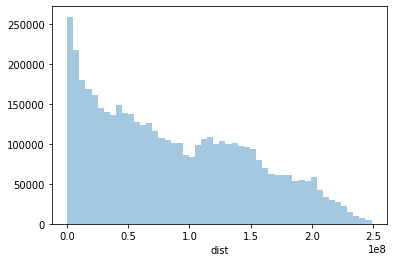

In [18]:
matrix_all_dist = []
#chr_list = list(range(1,23)) + ['X', 'Y']
chr_list = list(range(1,2))
df_go_id_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_mapping_v2.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
df_go_id_enseml.dropna(subset=['Gene stable ID'])
mydict_EID_UID = dict(zip(df_go_id_enseml['Transcript stable ID'], df_go_id_enseml['Gene stable ID']))
for chrm in chr_list:
    d_l = []
    
    for dist_type in ['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']:
        df_ensg_matrix = pd.read_csv('/data/lohia/gene_distance_expresseion/dist_files/%s/chr%s_%s.csv' %(dist_type, chrm, dist_type)) 
        df_ensg_matrix['ensg'] = [mydict_EID_UID[x.split(".")[0]] if x.split(".")[0] in df_go_id_enseml['Transcript stable ID'].to_list() else 'del' for x in df_ensg_matrix['Unnamed: 0'] ]
        print (df_ensg_matrix.shape)
        df_ensg_matrix.set_index('ensg', inplace = True)

        del df_ensg_matrix['Unnamed: 0']

        y = [mydict_EID_UID[x.split(".")[0]] if x.split(".")[0] in df_go_id_enseml['Transcript stable ID'].to_list() else 'del' for x in df_ensg_matrix.columns ]

        df_ensg_matrix.columns = y

        df_ensg_matrix.drop(['del'], inplace=True)

        del df_ensg_matrix['del']
        print (df_ensg_matrix.shape)

        duplicates = df_ensg_matrix.index.duplicated(keep='first')
        df_ensg_matrix = df_ensg_matrix.loc[~duplicates, ~duplicates]
        print (df_ensg_matrix.shape)

        subset_cols = list (set(exp_lee.index) & set(df_ensg_matrix.index))
        

        exp_subset = exp_lee.loc[subset_cols, subset_cols]
        df_ensg_subset = df_ensg_matrix.loc[subset_cols, subset_cols]

        long_form = df_ensg_subset.unstack()

        long_form.index.rename(['col_1', 'col_2'], inplace=True)

        long_form = long_form.to_frame(dist_type).reset_index()
        d_l.append(long_form[dist_type])

        df = long_form

    long_form = exp_subset.unstack()
    long_form = long_form.to_frame('exp').reset_index()

    

    df['exp'] = long_form['exp']
    for i,d  in zip(['tes_tes', 'tes_tss', 'tss_tes'], d_l):
        df[i] = d
    df['dist'] = df[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
    import seaborn as sns
    sns.distplot(df['dist'], hist=True, kde=False)
    matrix_all_dist.append((chrm, len(subset_cols), df))

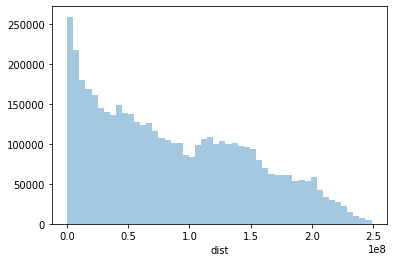

In [19]:
for chrm, num_pairs, df in matrix_all_dist[0:1]:
    df['dist'] = df[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
    import seaborn as sns
    sns.distplot(df['dist'], hist=True, kde=False)

In [20]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []
for chrm, num_pairs, df in matrix_all_dist:
    prot_list_sp = np.array_split(df, num_pairs, axis=0)
    for i in range(0,num_pairs):

        long_form_top = prot_list_sp[int(i)]
        long_form_top['dist'] = long_form_top[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
        #long_form_top['dist'] = long_form_top['tes_tes']
        #long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        #long_form_top = long_form_top[long_form_top["tm_score"] < 1]

        #print (long_form_top)
        long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
        #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
#        try: 
#           mp =  long_form_top['col_1'].values[0]
#           top_match_protein = long_form_top['col_2'].values[0]
#           dom_pair_a = long_form_top['max_dom_pair'].values[0][0] #this gets the domain pair with the highest matching 
#           dom_pair_b = long_form_top['max_dom_pair'].values[0][1]
#           real_tm_score = long_form_top["tm_score"].values[0]
#           para_dig =  long_form_top["paralogues_dig"].values[0]
#        except IndexError:
#           mp = ''
#           top_match_protein = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.6]
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()
        if exp_median >= 0.00:
            #long_form_top = long_form_top[~((long_form_top["exp"] > 0.2) & (long_form_top["exp"] < 0.8)) ]
            
            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
            #long_form_top = long_form_top.head(10)
            

            #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
            long_form_top = long_form_top.reset_index()
            long_form_top["True_sim"] = long_form_top["dist"] * 0
            

            
            try: 
                
                tmp_df = long_form_top[long_form_top.dist == long_form_top.dist.min()].sample()
                #print (long_form_top.head())
                #print (tmp_df)
                #print (tmp_df.index.values[0])
                #print ("--------")
                
                
                #long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
                long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
                
                
                mp =  long_form_top.loc[ tmp_df.index.values[0] , : ]['col_1']

                top_match_protein = long_form_top.loc[ tmp_df.index.values[0] , : ]['col_2']
                #dom_pair_a = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][0] #this gets the domain pair with the highest matching 
                #dom_pair_b = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][1]
                real_tm_score = long_form_top.loc[ tmp_df.index.values[0] , : ]["dist"]
                #para_dig =  long_form_top.loc[ tmp_df.index.values[0] , : ]["paralogues_dig"]
            except TypeError:
                mp = ''
                top_match_protein = ''
            #print ("here")
            #
            
            #rank(long_form_top["tm_score"].to_numpy())
            #rank(long_form_top['exp'].to_numpy())
            dist_thresh = 0
            for dist_thresh in [0]:
                #long_form_top["True_sim"] = [1 if score <= dist_thresh else 0 for score in long_form_top["dist"]]
                
                #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
                #long_form_top['true_pos_cum'] = long_form_top['True_sim'].cumsum()
                #long_form_top = long_form_top[long_form_top['true_pos_cum'] <=2]
                
                #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
                #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
                
                #long_form_top["True_sim"] = long_form_top["paralogues_dig"] 
                #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
                
                
                #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
                #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
                #print (long_form_top["True_sim"])
                #the top ten macthes are considered TP
                #print (long_form_top)
                #rank_abs = lambda x: stats.rankdata(np.abs(x))
                #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
                
                long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
                long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
                #print (long_form_top["true_pos"].sum())
                #print (long_form_top["true_neg"].sum())
                long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
                #print ("here2")
                
                ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
                m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
                pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

                tpd = pd.DataFrame(m_curve)
                if m_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    #print (tpd)
                    #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                    m_curve  = dict(zip(tpd.index, tpd[1]))
                   #print (m_curve)
                else:
                    m_curve  = {}
                tpd = pd.DataFrame(pr_curve)
                #print (pr_curve)
                if pr_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    #print (tpd)
                    #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                    pr_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    pr_curve  = {}
                m_l.append((chrm, num_pairs,dist_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, real_tm_score))
                
            #m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, dom_pair_a, dom_pair_b, real_tm_score, para_dig))
        else:
            pass

In [320]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'num_pairs','dist_thresh',  'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var', 'top_match_protein', 'real_tm_score'])

In [321]:
df_scores.dropna(inplace=True)

In [322]:
df_scores['gene_type'] = [mydict_EID_genetype[x] for x in df_scores['prot_name']]

In [323]:
df_scores['gene_type_2'] = [mydict_EID_genetype[x] for x in df_scores['top_match_protein']]

In [324]:
df_scores['gene_type_2'] = [1 if x=='protein_coding' else 0 for x in df_scores['gene_type_2']]

In [325]:
df_scores['gene_type'] = [1 if x=='protein_coding' else 0 for x in df_scores['gene_type']]

In [346]:
df_scores['gene_type'].sum()

1687

In [326]:
df_scores['gene_pair_type'] = df_scores['gene_type'] + df_scores['gene_type_2']

In [328]:
df_scores['gene_pair_type_protein_coding'] = [1 if x==2 else 0 for x in df_scores['gene_pair_type']]

In [329]:
df_scores['gene_pair_type_protein_coding_non_coding_pair'] = [1 if x==1 else 0 for x in df_scores['gene_pair_type']]

In [330]:
df_scores['gene_pair_type_non_coding_non_coding_pair'] = [1 if x==0 else 0 for x in df_scores['gene_pair_type']]

In [24]:
df_scores['nid'] = [mydict_EID_NID[x] for x in df_scores['prot_name'] ]

In [285]:
df_scores = df_scores.loc[df_scores['gene_type'] != 'protein_coding']

In [331]:
df_scores['presence'] = [1 if x > .99 else 0 for x in df_scores['auc'] ]

In [332]:
df_scores['presence2'] = [1 if x < .6 else 0 for x in df_scores['auc'] ]

In [236]:
df_scores['presence_gene_type'] = df_scores['presence'] * df_scores['gene_type']

In [237]:
df_scores['presence_gene_type2'] = df_scores['presence'] * df_scores['gene_type_2']

In [223]:
df_scores['presence'].sum()

535

In [333]:
df_chr1 = df_scores[['prot_name', 'presence', 'presence2', 'gene_type', 'gene_pair_type_protein_coding','gene_pair_type_protein_coding_non_coding_pair', 'gene_pair_type_non_coding_non_coding_pair']] 

In [334]:
df_chr1.set_index('prot_name', inplace=True)

In [26]:
df_scores.to_csv('/data/lohia/gene_distance_expresseion/chr1_auc.csv',index=False) 

In [99]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd


def fishers_exact(TP, TN, FP, FN):
    """Fishers exact for enrichment
	
	Input are values from a contigency tables
	
	Arguments:
		TP {int} -- Size of overlap
		TN {int} -- Size of both negative
		FP {int} -- Size of False Positive (Selected but not in query)
		FN {int} -- Size of False Negative (Not selected but in query)
	"""
    M = TP + TN + FP + FN
    n = TP + FN
    N = TP + FP
    #Have to use 1 - cdf to get correct density
    #We want selected P(TP or more)
    x = TP - 1
    return 1 - stats.hypergeom.cdf(x, M, n, N)

def enrichment(markerSet, referenceTerm):
    """Enrichment of a single gene set using Fisher's Exact
	
	Computes Fisher's Exact for a given marker set and reference term
	
	Arguments:
		markerSet {[type]} -- binary vector of gene set
		referenceTerm {[type]} -- binary vector of referenceTerm
	"""

    assert markerSet.shape[0] == referenceTerm.shape[
        0], 'Must have same list of all genes'

    TP = np.dot(markerSet, referenceTerm)
    FN = referenceTerm.sum() - TP
    FP = markerSet.sum() - TP
    TN = markerSet.shape[0] - (TP + FN + FP)
    return fishers_exact(TP, TN, FP, FN)

vector_exact = np.vectorize(
    lambda TP, TN, FP, FN: fishers_exact(TP, TN, FP, FN))

def enrichment_multi_reference(markers, reference):
    """Compute Enrichment between a list of markers and a list of references
	
	Computer enrichment, where markers is a list of cell-type markers and 
	the reference is all of GO
	
	Arguments:
		markers {np.array} -- Numpy 1-D array of float (0,1) for gene set membership
		reference {[type]} -- Numpy 2-D array of genes x terms of float (0,1) for term membership
	
	Returns:
		np.array -- 1-D array of BH adjusted P values
	"""
    assert markers.shape[0] == reference.shape[
        0], 'Must have same list of all genes'

    TP = markers @ reference
    #print (TP)
    FN = reference.sum(axis=0) - TP
    FP = np.sum(markers, axis=0) - TP
    TN = markers.shape[0] - (TP + FP + FN)
    p_val = vector_exact(TP, TN, FP, FN)
    p_adj = sm.stats.multipletests(p_val, method='fdr_bh')[1]
    
    return p_adj

def enrichment_df(markers_series, referenece_df):
    """Enrichment of Markers and Reference Network
    
    Computes enrichment of Markers and Reference Network from DataFrames
    
    Arguments:
        markers_series {pd.Series} -- Series of Marker Membership
        referenece_df {pd.DataFrame} -- DataFrame of Reference Gene List Memebership
    
    Returns:
        [type] -- [description]
    """
    shared_index = markers_series.index.intersection(referenece_df.index)
    
    padj = enrichment_multi_reference(
        markers_series.loc[shared_index].values.astype(float),
        referenece_df.loc[shared_index].values.astype(float))
    return pd.Series(padj, index=referenece_df.columns)

def enrich_multi_markers(markers_df, referenece_df):
    """Enrihcment of Multiple Markers Lists
    
    Apply's enrichment test to each marker list in marker df
    (Could Make a faster version if I fully vectorize the contingency table calculation)
    Arguments:
        markers_df {pd.DataFrame} -- genes x markers dataframe of membership
        referenece_df {pd.DataFrame} -- genes x terms dataframe of membership
    
    Returns:
        pd.DataFrame -- terms x marker names
        
    """
    #print (markers_df)
    return markers_df.apply(lambda x: enrichment_df(x, referenece_df))
    #return markers_df.apply(lambda x: enrichment_df(x,

In [280]:
go_df_intersect_fil = go_df_intersect.loc[:, (go_df_intersect.sum(axis=0) > 10)]

In [335]:
anno = df_chr1.drop(['presence' , 'presence2'], axis=1)

In [340]:
anno.sum()/2100

gene_type                                        0.803333
gene_pair_type_protein_coding                    0.649524
gene_pair_type_protein_coding_non_coding_pair    0.334286
gene_pair_type_non_coding_non_coding_pair        0.050000
dtype: float64

In [281]:
add_terms = go_df_intersect_fil.merge(df_chr1, left_on= go_df_intersect_fil.index , right_on=df_chr1.index)

In [282]:
add_terms.set_index('key_0', inplace=True)

In [284]:
add_terms_filter = add_terms[['gene_type']]

In [286]:
add_terms_filter.dropna()

gene_type
key_0                     
ENSG00000198691          1
ENSG00000143322          1
ENSG00000117054          1
ENSG00000143632          1
ENSG00000077522          1
...                    ...
ENSG00000162825          1
ENSG00000257315          1
ENSG00000271383          1
ENSG00000273136          1
ENSG00000162621          1

[1636 rows x 1 columns]

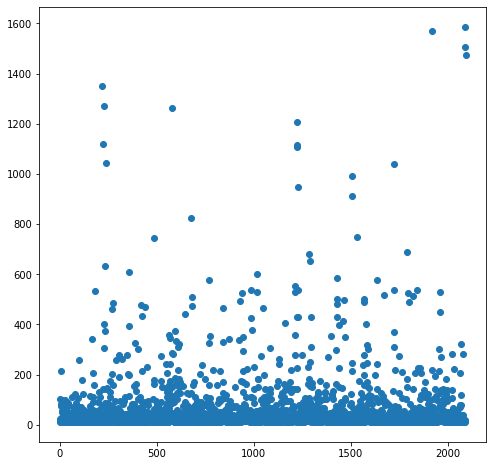

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharey=True)
ax.scatter(x=range(0,go_df_intersect_fil.shape[1]),y=go_df_intersect_fil.sum(axis=0))
#ax.set_ylim([0,200])

In [165]:
gene2go = pd.read_csv("/data/lohia/gene_distance_expresseion/gene2go", sep="\t")

In [167]:
gene2go_9606 = gene2go[gene2go["#tax_id"]==9606]

In [170]:
gene2go_9606.drop_duplicates(subset=['GO_ID'], inplace=True)

In [171]:
gene2go_9606

#tax_id     GeneID       GO_ID Evidence Qualifier  \
631690     9606          1  GO:0002576      TAS         -   
631691     9606          1  GO:0003674       ND         -   
631692     9606          1  GO:0005576      HDA         -   
631695     9606          1  GO:0005615      HDA         -   
631696     9606          1  GO:0008150       ND         -   
...         ...        ...         ...      ...       ...   
969382     9606  100133941  GO:0032597      IDA         -   
969383     9606  100133941  GO:0032600      ISS         -   
969384     9606  100133941  GO:0032913      IMP         -   
970188     9606  100506013  GO:0090133      ISS         -   
970778     9606  101928527  GO:1900101      IMP         -   

                                                  GO_term    PubMed   Category  
631690                             platelet degranulation         -    Process  
631691                                 molecular_function         -   Function  
631692                               extracellular region  27068509  Component  
631695                                extracellular space  16502470  Component  
631696                                 biological_process         -    Process  
...                                                   ...       ...        ...  
969382       B cell receptor transport into membrane raft  11313396    Process  
969383  chemokine receptor transport out of membrane raft         -    Process  
969384  negative regulation of transforming growth fac...  16930538    Process  
970188                              mesendoderm migration         -    Process  
970778  regulation of endoplasmic reticulum unfolded p...  31653868    Process  

[18417 rows x 8 columns]

In [337]:
v = enrich_multi_markers(df_chr1, anno)

In [338]:
v

presence  presence2  gene_type  \
gene_type                                      1.000000   0.000000        0.0   
gene_pair_type_protein_coding                  1.000000   0.991775        0.0   
gene_pair_type_protein_coding_non_coding_pair  0.000063   0.004223        1.0   
gene_pair_type_non_coding_non_coding_pair      0.009059   0.991775        1.0   

                                               gene_pair_type_protein_coding  \
gene_type                                                       0.000000e+00   
gene_pair_type_protein_coding                                   1.019185e-13   
gene_pair_type_protein_coding_non_coding_pair                   1.000000e+00   
gene_pair_type_non_coding_non_coding_pair                       1.000000e+00   

                                               gene_pair_type_protein_coding_non_coding_pair  \
gene_type                                                                       1.000000e+00   
gene_pair_type_protein_coding                                                   1.000000e+00   
gene_pair_type_protein_coding_non_coding_pair                                   6.224354e-12   
gene_pair_type_non_coding_non_coding_pair                                       1.000000e+00   

                                               gene_pair_type_non_coding_non_coding_pair  
gene_type                                                                   1.000000e+00  
gene_pair_type_protein_coding                                               1.000000e+00  
gene_pair_type_protein_coding_non_coding_pair                               1.000000e+00  
gene_pair_type_non_coding_non_coding_pair                                   6.896705e-12

In [313]:
v

presence  presence2  gene_type  gene_type_2
gene_type    0.000000        1.0    0.00000      0.12008
gene_type_2  0.999833        0.0    0.12008      0.00000

In [294]:
enriched_go_terms = v.merge(gene2go_9606, left_on=v.index, right_on=gene2go_9606.GO_ID )

In [296]:
enriched_go_terms[enriched_go_terms['presence'] < .045][['presence', 'GO_ID', 'GO_term', 'Category']]

Empty DataFrame
Columns: [presence, GO_ID, GO_term, Category]
Index: []

In [210]:
df_chr1

prot_name  presence  presence2  gene_pair_type  gene_type
0     ENSG00000163472         0          0               2          1
1     ENSG00000273112         1          0               0          0
2     ENSG00000143420         0          1               1          1
3     ENSG00000054277         1          0               2          1
4     ENSG00000117594         0          0               2          1
...               ...       ...        ...             ...        ...
2166  ENSG00000162836         0          0               2          1
2167  ENSG00000143418         0          0               2          1
2168  ENSG00000215915         0          0               2          1
2169  ENSG00000143387         1          0               2          1
2170  ENSG00000188783         1          0               2          1

[2171 rows x 5 columns]

In [185]:
df_chr1['presence2'].sum()

466

In [235]:
v[v['gene_type'] < .05]

Empty DataFrame
Columns: [presence, presence2, gene_type, gene_type_2]
Index: []

In [180]:
[go_df_intersect_fil[go_df_intersect_fil[x] == 1].index for x in enriched_go_term_list]

[Index(['ENSG00000143632', 'ENSG00000077522', 'ENSG00000035687',
        'ENSG00000162688', 'ENSG00000135744', 'ENSG00000004455',
        'ENSG00000143149', 'ENSG00000162551', 'ENSG00000240038',
        'ENSG00000158874',
        ...
        'ENSG00000264343', 'ENSG00000197915', 'ENSG00000143520',
        'ENSG00000207721', 'ENSG00000203814', 'ENSG00000162517',
        'ENSG00000198711', 'ENSG00000259823', 'ENSG00000183598',
        'ENSG00000272196'],
       dtype='object', length=403),
 Index(['ENSG00000198691', 'ENSG00000077522', 'ENSG00000163485',
        'ENSG00000282608', 'ENSG00000035687', 'ENSG00000162551',
        'ENSG00000117560', 'ENSG00000143761', 'ENSG00000155366',
        'ENSG00000152092',
        ...
        'ENSG00000235169', 'ENSG00000269113', 'ENSG00000197106',
        'ENSG00000197915', 'ENSG00000143520', 'ENSG00000168275',
        'ENSG00000189410', 'ENSG00000184454', 'ENSG00000263961',
        'ENSG00000259823'],
       dtype='object', length=485),
 Index(['ENSG0

In [175]:
enriched_go_terms[enriched_go_terms['presence2'] < .05]

key_0  presence  presence2  #tax_id  GeneID       GO_ID Evidence  \
139   GO:0003723       1.0   0.030848     9606      23  GO:0003723      HDA   
192   GO:0005622       1.0   0.001207     9606     308  GO:0005622      IDA   
193   GO:0005634       1.0   0.017733     9606      12  GO:0005634      TAS   
432   GO:0008104       1.0   0.041034     9606     190  GO:0008104      IDA   
898   GO:0033036       1.0   0.015374     9606    3929  GO:0033036      IDA   
1037  GO:0043227       1.0   0.007505     9606     746  GO:0043227      IBA   
1038  GO:0043229       1.0   0.002595     9606    6523  GO:0043229      ISS   
1039  GO:0043231       1.0   0.001207     9606      19  GO:0043231      IBA   

     Qualifier                                   GO_term             PubMed  \
139          -                               RNA binding  22658674|22681889   
192          -                             intracellular                  -   
193          -                                   nucleus           14668352   
432          -                      protein localization           11875111   
898          -                macromolecule localization           15294986   
1037         -                membrane-bounded organelle           21873635   
1038         -                   intracellular organelle                  -   
1039         -  intracellular membrane-bounded organelle           21873635   

       Category  
139    Function  
192   Component  
193   Component  
432     Process  
898     Process  
1037  Component  
1038  Component  
1039  Component

(0, 0.05)

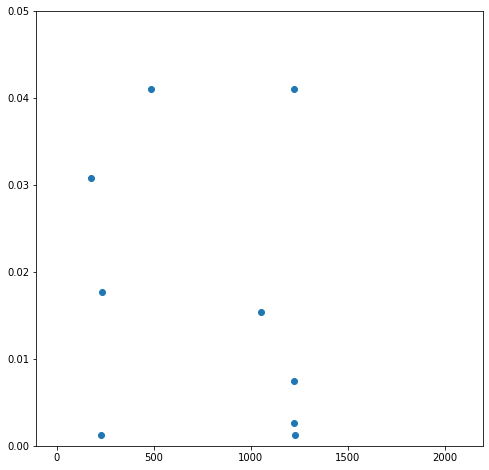

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharey=True)
ax.scatter(x=range(0,v.shape[0]),y=v.presence2)
ax.set_ylim([0,.05])

In [159]:
v.min()

presence     0.002245
presence2    0.001207
dtype: float64

In [229]:
df_chr1.set_index('prot_name', inplace=True)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [77]:
v

presence  presence2
GO:0000002       1.0        1.0
GO:0000003       1.0        1.0
GO:0000009       1.0        1.0
GO:0000010       1.0        1.0
GO:0000012       1.0        1.0
...              ...        ...
GO:2001306       1.0        1.0
GO:2001311       1.0        1.0
GO:0003674       1.0        1.0
GO:0005575       1.0        1.0
GO:0008150       1.0        1.0

[22517 rows x 2 columns]

In [76]:
print (v.min())

presence     1.0
presence2    1.0
dtype: float64


In [ ]:
df_chr1, go_df

In [123]:
genes_intersect = go_df.index.intersection(df_chr1.index)

In [124]:
genes_intersect

Index(['ENSG00000198691', 'ENSG00000143322', 'ENSG00000117054',
       'ENSG00000143632', 'ENSG00000077522', 'ENSG00000160710',
       'ENSG00000163485', 'ENSG00000282608', 'ENSG00000143799',
       'ENSG00000035687',
       ...
       'ENSG00000215784', 'ENSG00000196550', 'ENSG00000274386',
       'ENSG00000215845', 'ENSG00000271425', 'ENSG00000162825',
       'ENSG00000257315', 'ENSG00000271383', 'ENSG00000273136',
       'ENSG00000162621'],
      dtype='object', length=1636)

In [43]:
ch1_genes = df_chr1.prot_name.to_list()

In [125]:
go_df_intersect = go_df.loc[genes_intersect, :]

In [52]:
enrich_multi_markers(ch1_genes, go_df_intersect)

AttributeError: 'list' object has no attribute 'apply'

In [327]:
pd.crosstab(df_scores.gene_type != 'protein_coding', df_scores.auc > 0.99)

auc        False  True 
gene_type              
False       1363    324
True         272    212

In [306]:
from scipy.stats import fisher_exact
tab = pd.crosstab( df_scores.gene_type == 'protein_coding', df_scores.auc > 0.9)
fisher_exact(tab)

(0.33023165018219675, 5.165492880026167e-25)

In [291]:
df_scores[df_scores[0.00]>.99]

threshold  num_pairs  dist_thresh  auc                     pr_curve  \
35            1       2171            0  1.0  {1.0: 0.003806418667504885}   
102           1       2171            0  1.0  {1.0: 0.003806418667504885}   
122           1       2171            0  1.0  {1.0: 0.003806418667504885}   
153           1       2171            0  1.0  {1.0: 0.003806418667504885}   
170           1       2171            0  1.0  {1.0: 0.003806418667504885}   
...         ...        ...          ...  ...                          ...   
2115          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2119          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2120          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2122          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2133          1       2171            0  1.0  {1.0: 0.003806418667504885}   

      true_pos  true_neg        prot_name  exp_median  exp_mean  ...  0.91  \
35           1      2169  ENSG00000284735    0.361791  0.366787  ...   1.0   
102          1      2169  ENSG00000260920    0.724686  0.665667  ...   1.0   
122          1      2169  ENSG00000226419    0.543566  0.511762  ...   1.0   
153          1      2169  ENSG00000231691    0.157885  0.170043  ...   1.0   
170          1      2169  ENSG00000175147    0.435841  0.418541  ...   1.0   
...        ...       ...              ...         ...       ...  ...   ...   
2115         1      2169  ENSG00000238279    0.555043  0.509619  ...   1.0   
2119         1      2169  ENSG00000237424    0.621938  0.563109  ...   1.0   
2120         1      2169  ENSG00000228548    0.185501  0.212215  ...   1.0   
2122         1      2169  ENSG00000231407    0.527322  0.510189  ...   1.0   
2133         1      2169  ENSG00000232912    0.526828  0.499862  ...   1.0   

     0.92  0.93 0.94  0.95  0.96  0.97  0.98  0.99  1.0  
35    1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
102   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
122   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
153   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
170   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
...   ...   ...  ...   ...   ...   ...   ...   ...  ...  
2115  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2119  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2120  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2122  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2133  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  

[112 rows x 115 columns]

In [317]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [318]:
df_plot = df_scores.groupby(['dist_thresh']).mean()

In [319]:
df_scores.groupby(['dist_thresh']).mean()

threshold  num_pairs       auc  true_pos  true_neg  exp_median  \
dist_thresh                                                                   
0                  1.0     2171.0  0.772816       1.0    2169.0    0.613909   

             exp_mean   exp_var  real_tm_score           nid  ...      0.91  \
dist_thresh                                                   ...             
0            0.567448  0.050089   18596.102564  6.276304e+06  ...  0.990844   

                 0.92     0.93      0.94      0.95      0.96      0.97  \
dist_thresh                                                              
0            0.992006  0.99286  0.994272  0.994782  0.996157  0.996181   

                 0.98      0.99       1.0  
dist_thresh                                
0            0.996798  0.998695  0.999545  

[1 rows x 111 columns]

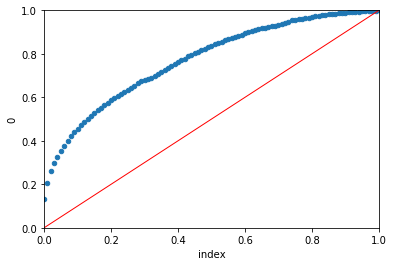

In [321]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[10::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

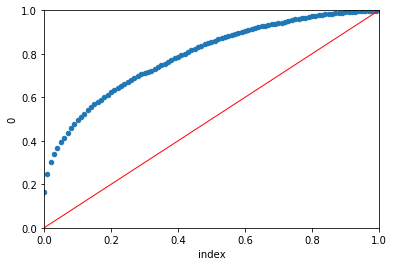

In [237]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[9::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

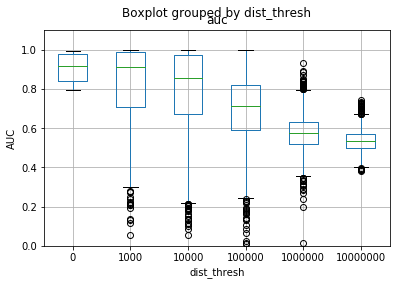

In [167]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='dist_thresh', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

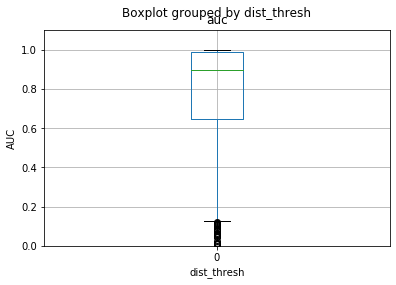

In [238]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='dist_thresh', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

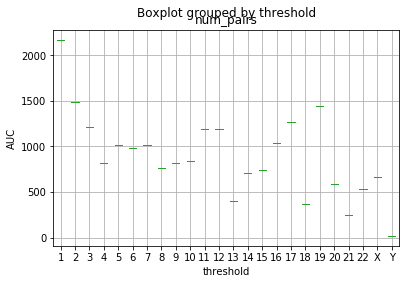

In [39]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['num_pairs'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
#axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()